In [1]:
import numpy as np 


import sys
import os

import jax
import jax.numpy as jnp 

import matplotlib.pyplot as plt

from kltpicker_3d.alt_least_squares import alternating_least_squares_solver
from kltpicker_3d.tests.exp_spectrum import *
from kltpicker_3d.tests.gaussian_spectrum import * 
from kltpicker_3d.tests.rpsd_test_data import generate_rpsd_data
from kltpicker_3d.tomogram import factorize_RPSD
from kltpicker_3d.utils import * 


plt.style.use('ggplot')

## Gaussian Spectrum

In [2]:
K = 200
N = 32
uniform_points, bins = generate_uniform_radial_sampling_points(N)
H, samples =  generate_rpsd_data(K,N,2)

/scratch/home/moshemaymon/3D_KLT/kltpicker_3d/tests/rpsd_test_data.py:31: ComplexWarning: Casting complex values to real discards the imaginary part
  samples[k] = sample[:N,:N,:N]


In [3]:
factorization = factorize_RPSD(samples)

/tmp/ipykernel_807015/3199449343.py:31: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[1,0].legend()


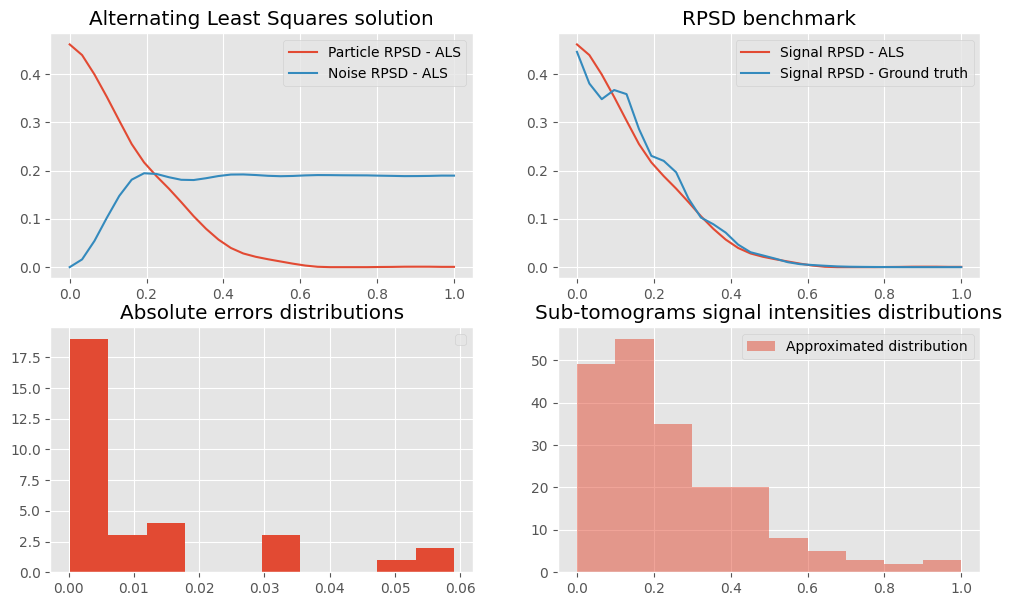

In [4]:
particle_psd = factorization.gamma
noise_psd = factorization.v

noise_psd /= np.linalg.norm(noise_psd)
particle_psd /= np.linalg.norm(particle_psd)


fig, ax = plt.subplots(2,2, figsize=(12,7))

extracted_alphas = factorization.alpha

H /= np.linalg.norm(H)

true_rpsd = radial_average(H,bins,N)
true_rpsd /= np.linalg.norm(true_rpsd)

ax[0,0].plot(uniform_points,particle_psd, label='Particle RPSD - ALS')
ax[0,0].plot(uniform_points,noise_psd, label='Noise RPSD - ALS')
ax[0,0].set_title("Alternating Least Squares solution")
ax[0,0].legend()


ax[0,1].plot(uniform_points,particle_psd,label='Signal RPSD - ALS')
ax[0,1].plot(uniform_points,true_rpsd, label='Signal RPSD - Ground truth')
ax[0,1].legend()
ax[0,1].set_title("RPSD benchmark")
ax[0,1].legend()

ax[1,0].set_title("Absolute errors distributions")
ax[1,0].hist(np.abs(true_rpsd - particle_psd));
ax[1,0].legend()

ax[1,1].set_title("Sub-tomograms signal intensities distributions")
ax[1,1].hist(extracted_alphas,alpha=0.5, label='Approximated distribution')
ax[1,1].legend();

In [ ]:
import scipy
from scipy.special import legendre
import scipy.integrate as integrate

def cpu_integral_equation_solver(Gx,N,K=150):
  def Hn(x):
    p = legendre(N)
    if N % 2 == 0:
        return 4 * np.pi * integrate.quad(lambda u: np.cos(x*u) * p(u), 0,1)[0]
    return 4 * np.pi * integrate.quad(lambda u: np.sin(x*u),0,1)[0]
  
  X,w = scipy.special.roots_legendre(K)
  X_scaled = 0.5*X + 0.5

  vv = np.array([[Hn(X_scaled[i]*X_scaled[j]) for j in range(K)] for i in range(K)])
  def psi(i,j):
    return 0.5 * np.sum(w * vv[j,:] * vv[i,:] * Gx * (X_scaled[j]*X_scaled)**2)

  U = np.array([[w[j]*psi(i,j) for j in range(K)] for i in range(K)])

  eigenvalues, eigenvectors = scipy.linalg.eig(U)
  return eigenvalues,eigenvectors

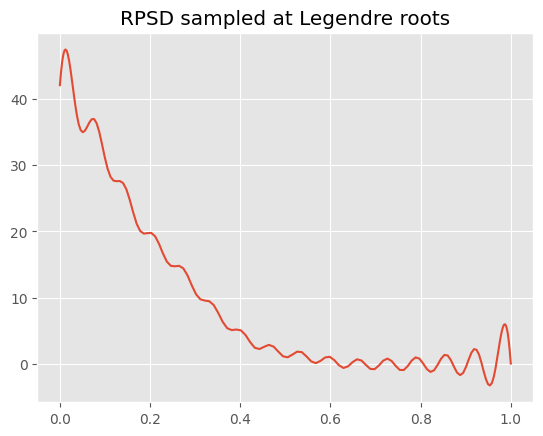

In [6]:
particle_psd = factorization.gamma
X,w = scipy.special.roots_legendre(150)
X_scaled = 0.5*X + 0.5
Gx = trigonometric_interpolation(uniform_points, particle_psd, X_scaled)
true_G = (1/np.sqrt(2*np.pi * 1 ** 2)) * np.exp(- X_scaled ** 2 / (2*1 ** 2)) * (1 + 0.1 * np.cos(10*X_scaled))
plt.title("RPSD sampled at Legendre roots")
plt.plot(X_scaled, Gx);

In [148]:
order = 10
eigenvalues, eigenfunctions = cpu_integral_equation_solver(Gx,order)
eigenvalues = np.absolute(eigenvalues)
indices = np.argsort(eigenvalues)[::-1]

/scratch/home/moshemaymon/.conda/envs/moshiko/lib/python3.10/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/scratch/home/moshemaymon/.conda/envs/moshiko/lib/python3.10/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


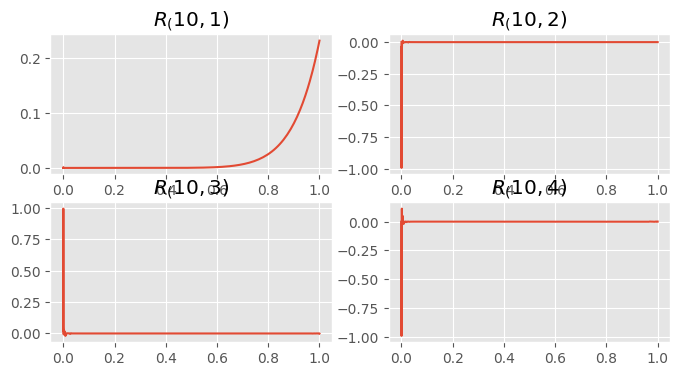

In [149]:
fig, ax = plt.subplots(2,2, figsize=(8,4))


ax[0,0].plot(X_scaled,eigenfunctions[:,indices[0]])
ax[0,0].set_title(f"$R_{10,1}$")


ax[0,1].plot(X_scaled,eigenfunctions[:,indices[20]])
ax[0,1].set_title(f"$R_{order,2}$")

ax[1,0].plot(X_scaled,eigenfunctions[:,indices[2]])
ax[1,0].set_title(f"$R_{order,3}$")

ax[1,1].plot(X_scaled,eigenfunctions[:,indices[6]])
ax[1,1].set_title(f"$R_{order,4}$");

After plotting a few it seems as if for a given order N, the eigenfunctions $R_{N,m}$ are redundant for $m>1$.

Note the solutions are of the form:

$$ \psi_{N,m,n}(r,\theta,\phi) = R_{N,m}(r) Y_n^m(\theta,\phi)$$

This function is 4-dimensional hence instead we will visualize slices of it. As the Spherical Harmonics are defined:

$$ Y_n^m(\theta, \phi) = \sqrt{\frac{2n+1}{4 \pi} \frac{(n-m)!}{(n+m)!}} e^{im\theta} P_n^m(\cos(\phi))$$ 

We cana fix $\phi=0$ and plot the eigenfunction up to a constant.

/tmp/ipykernel_807015/526913387.py:13: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(X, Y, R_2d,cmap='viridis')


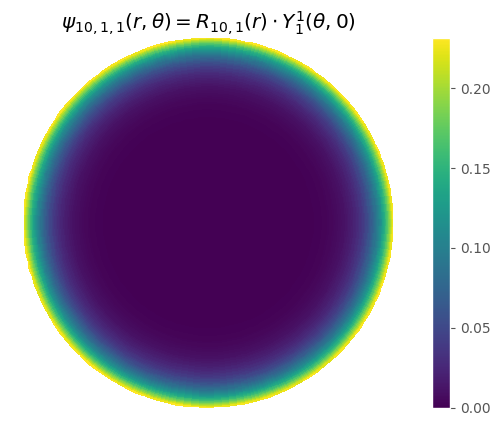

In [151]:
N = 150 
R = eigenfunctions[:,indices[0]].real 

theta = np.linspace(0, 2*np.pi, N)

theta_g, r_g = np.meshgrid(theta, X_scaled )

X = r_g * np.cos(theta_g)
Y = r_g * np.sin(theta_g)

R_2d = np.tile(R[:, np.newaxis], (1, N))

plt.pcolormesh(X, Y, R_2d,cmap='viridis')
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.axis('equal')
plt.title(r'$\psi _{10,1,1}(r, \theta) = R_{10,1}(r) \cdot Y_1^1(\theta, 0)$')
plt.colorbar()
plt.axis('off');

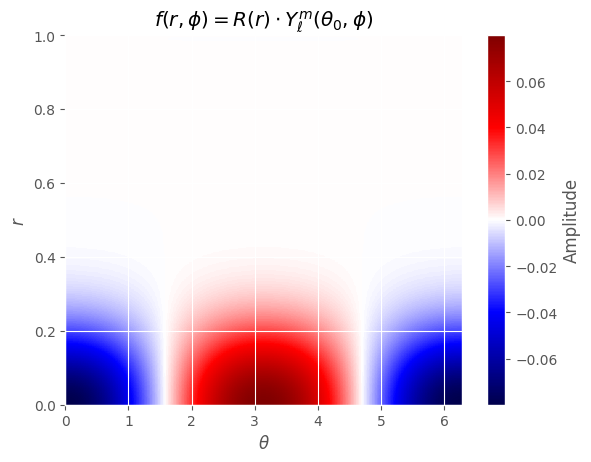

In [ ]:
from scipy.special import sph_harm

N = 150 
R = eigenfunctions[:,indices[0]].real 

l,m = 1,1
phi = np.pi/2
theta0 = np.linspace(0, 2*np.pi, N)
Y = np.real(sph_harm(m,l,theta0, phi))

psi = np.outer(R, Y)

Y_min, Y_max = Y.min(), Y.max()
Y_norm = 2 * (Y - Y_min)/(Y_max - Y_min) - 1
Y_colors = 0.5 * (Y_norm + 1)

psi = np.outer(R,Y)
plt.imshow(psi, aspect='auto', 
           extent=[0,2*np.pi,0,1.0],
           cmap='seismic')
plt.xlabel(r'$\theta$')
plt.ylabel(r'$r$')
plt.title(r'$f(r, \phi) = R(r) \cdot Y_\ell^m(\theta_0, \phi)$')
plt.colorbar(label='Amplitude')
plt.show()



In [134]:
order = 1
eigenvalues, eigenfunctions = cpu_integral_equation_solver(Gx,order)
eigenvalues = np.absolute(eigenvalues)
indices = np.argsort(eigenvalues)[::-1]

/tmp/ipykernel_807015/1450967156.py:13: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(X, Y, R_2d, shading='auto',cmap='seismic')


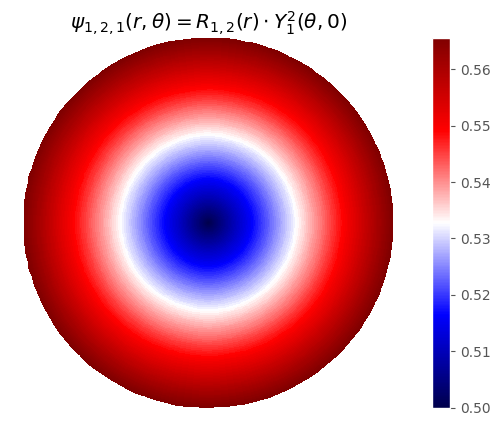

In [ ]:
N = 150 
R = eigenfunctions[:,indices[0]].real 

theta = np.linspace(0, 2*np.pi, N)

theta_g, r_g = np.meshgrid(theta, X_scaled )

X = r_g * np.cos(theta_g)
Y = r_g * np.sin(theta_g)

R_2d = np.tile(R[:, np.newaxis], (1, N))

plt.pcolormesh(X, Y, R_2d, shading='auto',cmap='seismic')
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.axis('equal')
plt.title(r'$\psi _{1,2,1}(r, \theta) = R_{1,2}(r) \cdot Y_1^2(\theta, 0)$')
plt.colorbar()
plt.axis('off');

## Power Law Spectra

In [175]:
vect_spectrum_estimation = jax.vmap(estimate_isotropic_powerspectrum_tensor,
                                    in_axes=(0,None))

In [267]:
K = 200
N = 32
M = 2*N - 1 
max_d = int(np.floor(N/3))

uniform_points, bins = generate_uniform_radial_sampling_points(N)

T = -np.log(1e-15)/30
grid = np.arange(-(N-1),N)
i,j,k = np.meshgrid(grid,grid,grid)
r = np.sqrt(i**2 + j**2 + k**2) 
H = 1/(( 1+ r**2) ** 0.5)
C = M**3 / H.sum()
normalized_H = jnp.fft.ifftshift(jnp.sqrt(H * C))

samples = np.zeros((K,N,N,N))
alphas = np.random.beta(2,5,size=(K))   

std = 1
for i in range(K):
    gaussian_noise = np.random.normal(size=(M,M,M))
    additive_noise = np.random.normal(scale=std,size=(M,M,M))
    sample = jnp.fft.ifftn(jnp.fft.fftn(gaussian_noise) * normalized_H)
    sample = alphas[i]*sample + additive_noise
    samples[i] = sample[:N,:N,:N].real

In [268]:
samples = samples - jnp.mean(samples, axis=(1,2,3)).reshape(-1,1,1,1)
psds = vect_spectrum_estimation(samples,max_d)

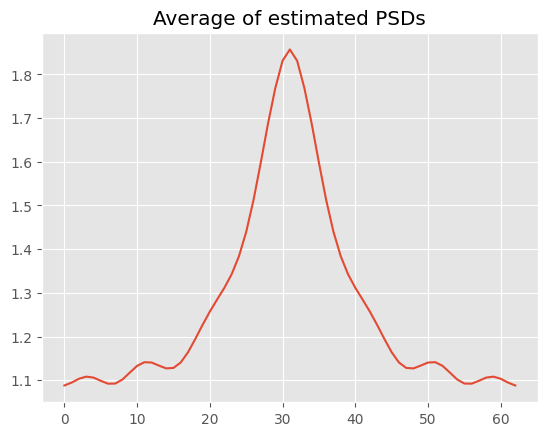

In [269]:
plt.title("Average of estimated PSDs");
plt.plot(np.mean(psds,axis=0)[N,N,:]);

In [270]:
rblocks = np.array([radial_average(psds[k], bins, N) for k in range(K)])
factorization = alternating_least_squares_solver(rblocks,500,1e-4)

/tmp/ipykernel_807015/3199449343.py:31: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[1,0].legend()


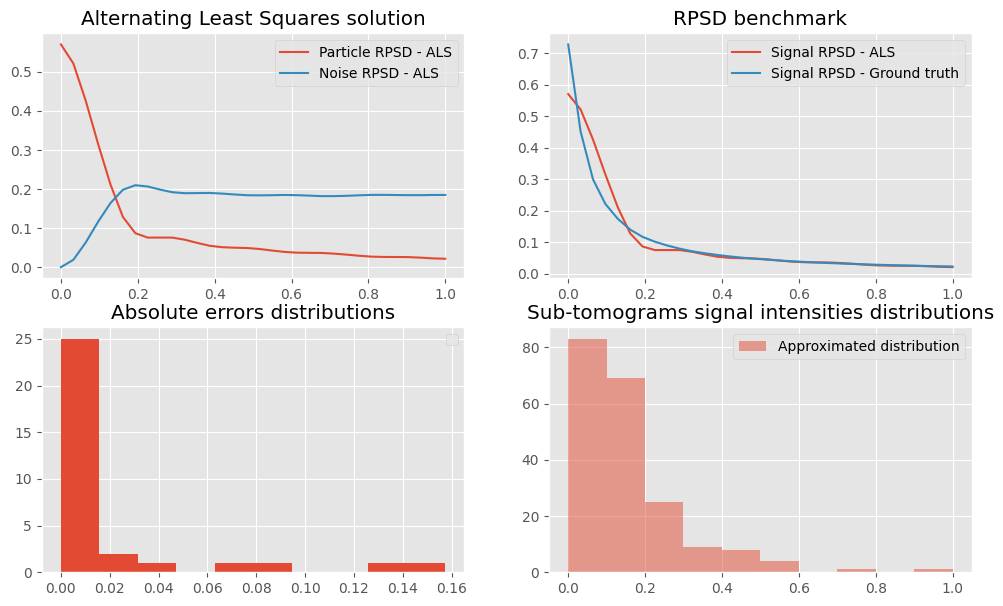

In [271]:
particle_psd = factorization.gamma
noise_psd = factorization.v

noise_psd /= np.linalg.norm(noise_psd)
particle_psd /= np.linalg.norm(particle_psd)


fig, ax = plt.subplots(2,2, figsize=(12,7))

extracted_alphas = factorization.alpha

H /= np.linalg.norm(H)

true_rpsd = radial_average(H,bins,N)
true_rpsd /= np.linalg.norm(true_rpsd)

ax[0,0].plot(uniform_points,particle_psd, label='Particle RPSD - ALS')
ax[0,0].plot(uniform_points,noise_psd, label='Noise RPSD - ALS')
ax[0,0].set_title("Alternating Least Squares solution")
ax[0,0].legend()


ax[0,1].plot(uniform_points,particle_psd,label='Signal RPSD - ALS')
ax[0,1].plot(uniform_points,true_rpsd, label='Signal RPSD - Ground truth')
ax[0,1].legend()
ax[0,1].set_title("RPSD benchmark")
ax[0,1].legend()

ax[1,0].set_title("Absolute errors distributions")
ax[1,0].hist(np.abs(true_rpsd - particle_psd));
ax[1,0].legend()

ax[1,1].set_title("Sub-tomograms signal intensities distributions")
ax[1,1].hist(extracted_alphas,alpha=0.5, label='Approximated distribution')
ax[1,1].legend();

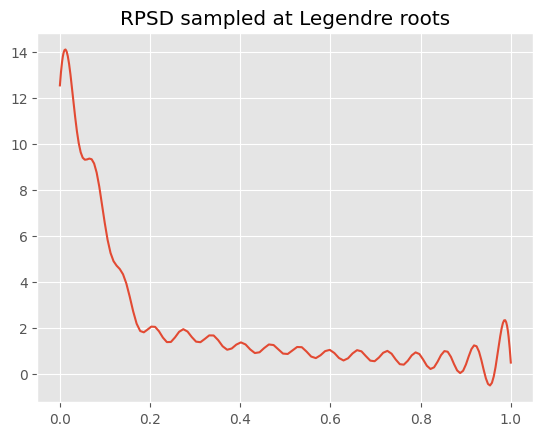

In [272]:
import scipy
from scipy.special import legendre
import scipy.integrate as integrate

def cpu_integral_equation_solver(Gx,N,K=150):
  def Hn(x):
    p = legendre(N)
    if N % 2 == 0:
        return 4 * np.pi * integrate.quad(lambda u: np.cos(x*u) * p(u), 0,1)[0]
    return 4 * np.pi * integrate.quad(lambda u: np.sin(x*u),0,1)[0]
  
  X,w = scipy.special.roots_legendre(K)
  X_scaled = 0.5*X + 0.5

  vv = np.array([[Hn(X_scaled[i]*X_scaled[j]) for j in range(K)] for i in range(K)])
  def psi(i,j):
    return 0.5 * np.sum(w * vv[j,:] * vv[i,:] * Gx * (X_scaled[j]*X_scaled)**2)

  U = np.array([[w[j]*psi(i,j) for j in range(K)] for i in range(K)])

  eigenvalues, eigenvectors = scipy.linalg.eig(U)
  return eigenvalues,eigenvectors

particle_psd = factorization.gamma
X,w = scipy.special.roots_legendre(150)
X_scaled = 0.5*X + 0.5
Gx = trigonometric_interpolation(uniform_points, particle_psd, X_scaled)
plt.title("RPSD sampled at Legendre roots")
plt.plot(X_scaled, Gx);

In [277]:
order = 1
eigenvalues, eigenfunctions = cpu_integral_equation_solver(Gx,order)
eigenvalues = np.absolute(eigenvalues)
indices = np.argsort(eigenvalues)[::-1]

/tmp/ipykernel_807015/147154175.py:16: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(X, Y, R_2d,cmap='seismic')


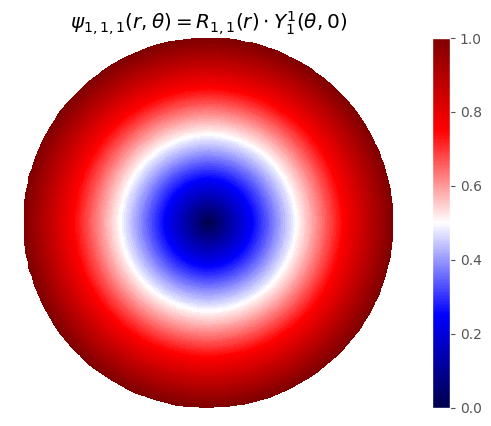

In [278]:
N = 150 
R = eigenfunctions[:,indices[0]].real 

theta = np.linspace(0, 2*np.pi, N)

theta_g, r_g = np.meshgrid(theta, X_scaled )

X = r_g * np.cos(theta_g)
Y = r_g * np.sin(theta_g)


R_norm = 2*(R - R.min())/(R.max() - R.min()) - 1
R_colors = 0.5*(R_norm + 1)
R_2d = np.tile(R_colors[:, np.newaxis], (1, N))

plt.pcolormesh(X, Y, R_2d,cmap='seismic')
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.axis('equal')
plt.title(r'$\psi _{1,1,1}(r, \theta) = R_{1,1}(r) \cdot Y_1^1(\theta, 0)$')
plt.colorbar()
plt.axis('off');